# Goal: Align raw tiles to a stitched volume

## Step 0. Parameter setup

In [1]:
import h5py
import numpy as np
import os
import exm
import matplotlib.pyplot as plt
import tifffile
import multiprocessing as mp
from exm.io import readXlsx, readNd2,tiles, readH5, writeH5, mkdir, tilesData,imAdjust,tiff2H5
from exm.align import sitkTile, sitkTile2Volume


############# To change #############
## 1. File paths
# input
D0 = '/mp/nas3/WORMSeq7_Full3Rounds/WORMseq7_YoungAdult/'
Ds = D0 + 'WORMseq7_YoungAdult_barcode3/Base3/output/'
# output
Do = '/home/donglai/align/db/wormseq7/'


## 2. Stitched volume: convert tif output to h5
#align_method = 'bigstitcher'
align_method = 'terastitcher'
bigstitcher_h5 = Do + 'barcode3_hr.h5'
# if no h5 yet, need conversion
terastitcher_hr_tif = Ds + 'RES(9854x5950x548)/000000/000000_000000/000000_000000_000040.tif'
terastitcher_lr_tif = Ds + 'RES(1231x743x68)/000000/000000_000000/000000_000000_000040.tif'



## 3. Tiles from other rounds
#fn_name = 'barcode5'
fn_name = 'barcode6'
fn_tiles_folder = D0 + 'WORMseq7_YoungAdult_%s/' % fn_name
fn_tiles_nd2 = fn_tiles_folder + 'Channel405 SD_Seq0004.nd2' 
fn_tiles_channel = '405 SD'
fn_tiles_xlsx = fn_tiles_folder + 'YoungAdult_%s_405.xlsx' % fn_name


## 4. Registration
# threshold the range to change from uint16 to uint8
# do not rescale the tiles as some background tiles can be over-scaled
transform_type = 'rigid' # good enough, more robust
#transform_type = 'affine'
mip_lr = 3 # for low-res registration
im_thres = [0, 255, False] 

do_debug = True # for debug


############# No change #############
ratio_lr = [2**mip_lr for i in range(3)]
stitched_hr_h5 = Do + 'barcode3_hr.h5'
stitched_lr_h5 = Do + 'barcode3_lr.h5'
Do = Do + '/'
mkdir(Do)
mkdir(Do + fn_name)
fn_out = Do + fn_name + '/'+ transform_type + '_%d-%d'

# save intermediate low-res results
mkdir(Do + 'lr/')
sn_tiles_lr = Do + 'lr/%s_lr-raw.h5' % fn_name
sn_transform_lr = Do + 'lr/%s_lr-raw_%s.txt' % (fn_name, transform_type)
sn_tiles_warp_lr = Do + 'lr/%s_lr-raw_%s_warped.h5' % (fn_name, transform_type)

# Step 0. Data conversion

In [2]:
if not os.path.exists(stitched_hr_h5):
    tiff2H5(terastitcher_hr_tif, stitched_hr_h5, chunk_size=(100,1024,1024), step=100)

if align_method == 'bigstitcher':
    stitched_hr_h5_vol = h5py.File(stitched_hr_h5, 'r')['t00000']['s00']['0']['cells']
elif align_method == 'terastitcher':
    stitched_hr_h5_vol = h5py.File(stitched_hr_h5, 'r')['main']

## Step 1. Low-res volume-to-volume registration

### 1.1 Low-res stitched volume

In [3]:
if align_method == 'bigstitcher':
    stitched_lr_h5_vol = np.array(h5py.File(bigstitcher_h5, 'r')['t00000']['s00'][str(mip_lr)]['cells'])    
elif align_method == 'terastitcher':
    if not os.path.exists(stitched_lr_h5):
        stitched_lr_vol = tifffile.imread(terastitcher_lr_tif)
        writeH5(stitched_lr_h5, stitched_lr_vol)
    else:
        stitched_lr_vol = readH5(stitched_lr_h5)
    stitched_lr_h5_vol = h5py.File(stitched_lr_h5, 'r')['main']

In [4]:
if do_debug and False:
    # check out the image value distribution
    stitched_lr_vol = np.array(stitched_lr_h5_vol)
    plt.hist(stitched_lr_vol[stitched_lr_vol>0])
    plt.yscale('log')

### 1.2 Low-res naive-stitch from xlsx

In [5]:
tiles_nd2, tiles_info = readNd2(fn_tiles_nd2)
tiles_loc = readXlsx(fn_tiles_xlsx)


tiles_data = tilesData(tiles_nd2, tiles_info, tiles_loc)
tiles_data.setChannel(fn_tiles_channel)
tiles_data.setRatio(ratio_lr)
tiles_data.setImThres(im_thres)

if not os.path.exists(sn_tiles_lr):
    tiles_lr_vol = tiles_data.getTileRawStitch()
    writeH5(sn_tiles_lr, tiles_lr_vol)
else:
    tiles_lr_vol = readH5(sn_tiles_lr)

exist 3 multipoint loops with length [4 4 9]
['405 SD']
original size:  [ 430 9819 5969] (downsampled): [  54 1228  747]


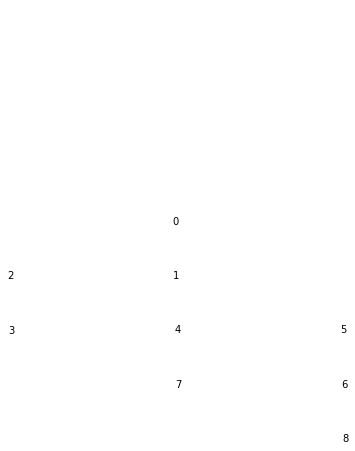

In [6]:
if do_debug:
    # display tile layout
    tiles_data.displayTileLoc()

In [7]:
if do_debug and False:
    # check out the image value distribution
    plt.hist(tiles_lr_vol[tiles_lr_vol>0])
    plt.yscale('log')

### 1.3 Compute registration

In [8]:
aligner = sitkTile()
# zyx -> xyz order
aligner.setResolution(tiles_data.getResolution(ratio_lr)[::-1])
aligner.setTransformType([transform_type], num_iteration=5000)

if not os.path.exists(sn_transform_lr):
    transform_lr = aligner.computeTransformMap(stitched_lr_vol, tiles_lr_vol,\
                                mask_fix = (stitched_lr_vol>0).astype(np.uint8),\
                                mask_move = (tiles_lr_vol>0).astype(np.uint8))
    aligner.writeTransformMap(sn_transform_lr, transform_lr)
else:
    transform_lr = aligner.readTransformMap(sn_transform_lr)

In [9]:
## visualization for napari
if not os.path.exists(sn_tiles_warp_lr):
    tiles_lr_warp = aligner.warpVolume(tiles_lr_vol, transform_lr).astype(np.uint8)
    writeH5(sn_tiles_warp_lr, tiles_lr_warp)

In [10]:
transform_lr['Spacing']

('1.300000', '1.300000', '3.200000')

## [Optional] Step 2. Low-res tile-to-volume alignment

In [11]:
do_sanity_check = False
#do_sanity_check = True

if do_sanity_check:
    ### 2.1 Compute registration
    aligner_t2s = sitkTile2Volume(tiles_data, stitched_lr_h5_vol, aligner, ratio_lr)
    aligner_t2s.setInitialTransform(transform_lr)
    aligner_t2s.updateOutputSize(pad_ratio = 3)

    for tile_id in range(tiles_data.tiles_num):
        #if True:
        if not os.path.exists(fn_out%(ratio_lr[0], tile_id) + '.h5') and not os.path.exists(fn_out%(ratio_lr[0], tile_id) + '_err.h5'):
            print('process tile:', tile_id)
            aligner_t2s.alignTiles(tile_id, fn_out, True)


    ### 2.2 Render result        
    aligner_t2s.stitchTiles(fn_out, (50,512,512))

## [Final result] Step 3. High-res tile-to-volume alignment

In [ ]:
ratio_hr = [1,1,1]
aligner_t2s = sitkTile2Volume(tiles_data, stitched_hr_h5_vol, aligner, ratio_hr)
aligner_t2s.setInitialTransform(transform_lr)
aligner_t2s.updateOutputSize(pad_ratio = 3)


# naive sequential approach
for tile_id in range(tiles_data.tiles_num):    
    if not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '.h5') and \
        not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '_err.h5'):
        print(tile_id)
        aligner_t2s.alignTiles(tile_id, fn_out)
"""

## doesn't work due to nd2 doesn't support concurrent read
def worker(tile_id):
    if not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '.h5'):
        print('working on tile', tile_id)
        aligner_t2s.alignTiles(tile_id, fn_out)

pool = mp.Pool(min(tiles_data.tiles_num, mp.cpu_count()))
pool.map(worker, range(tiles_data.tiles_num))
"""

original size:  [ 430 9819 5969] (downsampled): [ 431 9820 5970]
0


In [ ]:
# render mip0 results
out = aligner_t2s.stitchTiles(fn_out, (100,1024,1024))

In [ ]:
# downsample for visual debugging
fi = fn_out[:fn_out.rfind('/')] + '_stitched-%d.h5'%(ratio_high[0])
vol = readH5(fi)
writeH5(fi[:-3]+'_dsx8.h5', vol[::8,::8,::8])